In [1]:
# Import all libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

In [2]:
# Define emotion labels for the model
emotion_labels = {0: "Happy", 1: "Surprise", 2: "Sad", 3: "Anger", 4: "Disgust", 5: "Fear", 6: "Neutral"}

# Load and Preprocess RAF-DB Dataset
class RAFDBDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # RAF-DB labels: 1=Surprise, 2=Fear, 3=Disgust, 4=Happy, 5=Sad, 6=Anger, 7=Neutral
        # Desired mapping: Happy=0, Surprise=1, Sad=2, Anger=3, Disgust=4, Fear=5, Neutral=6
        self.label_map = {1: 1, 2: 5, 3: 4, 4: 0, 5: 2, 6: 3, 7: 6}

        # Dynamically load images and labels from folder structure
        self.image_data = []
        for class_folder in os.listdir(img_dir):
            class_path = os.path.join(img_dir, class_folder)
            if os.path.isdir(class_path) and class_folder.isdigit():
                label = int(class_folder)
                if label in self.label_map:
                    for filename in os.listdir(class_path):
                        if filename.endswith(".jpg") or filename.endswith(".png"):
                            self.image_data.append([filename, label])

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_name, original_label = self.image_data[idx]
        mapped_label = self.label_map[original_label]
        img_path = os.path.join(self.img_dir, str(original_label), img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, mapped_label

# Load and Preprocess FER-2013 Dataset (Updated for directory structure)
class FER2013Dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # FER-2013 emotion folders to desired labels
        self.label_map = {
            'happy': 0, 'surprise': 1, 'sad': 2, 'angry': 3,
            'disgust': 4, 'fear': 5, 'neutral': 6
        }
        self.image_data = []

        for emotion in os.listdir(img_dir):
            emotion_path = os.path.join(img_dir, emotion)
            if os.path.isdir(emotion_path) and emotion in self.label_map:
                for filename in os.listdir(emotion_path):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.image_data.append((os.path.join(emotion_path, filename), self.label_map[emotion]))

        if not self.image_data:
            raise ValueError(f"No images found in {img_dir}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path, label = self.image_data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load raf-db datasets
base_path_rafdb = "/kaggle/input/raf-db-dataset"
train_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/train")
test_img_dir_rafdb = os.path.join(base_path_rafdb, "DATASET/test")

# Load fer-2013 datasets
base_path_fer2013 = "/kaggle/input/fer2013"  # Adjust this path based on actual location
train_img_dir_fer2013 = os.path.join(base_path_fer2013, "train")
test_img_dir_fer2013 = os.path.join(base_path_fer2013, "test")

# Check paths if not exist
for path in [train_img_dir_rafdb, test_img_dir_rafdb, train_img_dir_fer2013, test_img_dir_fer2013]:
    if not os.path.exists(path):
        print(f"Warning: Directory not found at {path}")

# Load RAF-DB and FER-2013 training datasets
rafdb_train_dataset = RAFDBDataset(img_dir=train_img_dir_rafdb, transform=train_transforms)
fer2013_train_dataset = FER2013Dataset(img_dir=train_img_dir_fer2013, transform=train_transforms)

# Combine datasets
full_train_dataset = ConcatDataset([rafdb_train_dataset, fer2013_train_dataset])

# Split into train and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Load test datasets
rafdb_test_dataset = RAFDBDataset(img_dir=test_img_dir_rafdb, transform=test_transforms)
fer2013_test_dataset = FER2013Dataset(img_dir=test_img_dir_fer2013, transform=test_transforms)

# Combine test datasets
combined_test_dataset = ConcatDataset([rafdb_test_dataset, fer2013_test_dataset])

# Print dataset sizes
print(f"Total Training Data (RAF-DB + FER-2013): {len(full_train_dataset)}")
print(f"Training Split: {len(train_dataset)}")
print(f"Validation Split: {len(val_dataset)}")
print(f"Test Set (RAF-DB + FER-2013): {len(combined_test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=False)

# Batch shape check
train_image, train_label = next(iter(train_loader))
print(f"\nTrain batch: Image shape {train_image.shape}, Label shape {train_label.shape}")
val_image, val_label = next(iter(val_loader))
print(f"Validation batch: Image shape {val_image.shape}, Label shape {val_label.shape}")
test_image, test_label = next(iter(test_loader))
print(f"Test batch: Image shape {test_image.shape}, Label shape {test_label.shape}")

Total Training Data (RAF-DB + FER-2013): 40980
Training Split: 32784
Validation Split: 8196
Test Set (RAF-DB + FER-2013): 10246

Train batch: Image shape torch.Size([64, 3, 256, 256]), Label shape torch.Size([64])
Validation batch: Image shape torch.Size([64, 3, 256, 256]), Label shape torch.Size([64])
Test batch: Image shape torch.Size([64, 3, 256, 256]), Label shape torch.Size([64])


Number of images processed in this batch: 64
Number of images displayed: 8


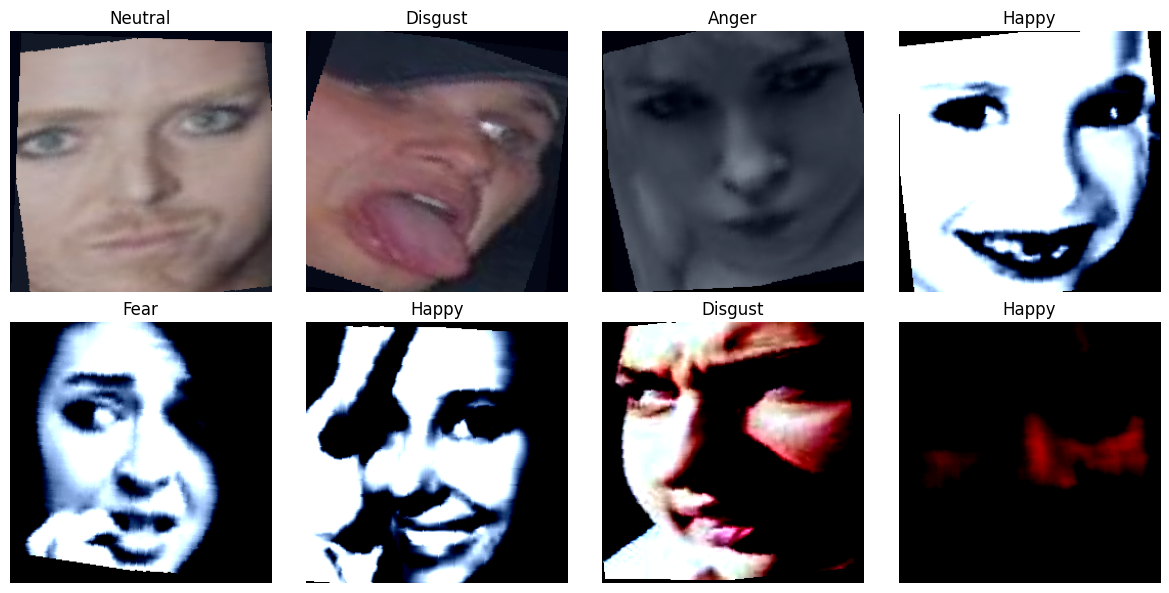

In [3]:
# After augmentation
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse normalization: (tensor * std) + mean
    return tensor

# Get a batch of training images
images, labels = next(iter(train_loader))

# Denormalize images for visualization
images = denormalize(images)

# Print the number of images in the batch
print(f"Number of images processed in this batch: {images.shape[0]}")
print(f"Number of images displayed: 8")

# Plot the first 8 images in the batch
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    img = np.clip(img, 0, 1)  # Ensure pixel values are in [0, 1]
    axes[i].imshow(img)  # Since images are grayscale with 3 channels, this will show as grayscale
    axes[i].set_title(emotion_labels[labels[i].item()])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Define Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define ResEmoteNet Model
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.6)
        self.dropout_res = nn.Dropout(0.3)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn_fc3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, 7)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        x = self.res_block1(x)
        x = self.dropout_res(x)
        x = self.res_block2(x)
        x = self.dropout_res(x)
        x = self.res_block3(x)
        x = self.dropout_res(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn_fc3(self.fc3(x)))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Initialize device, model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResEmoteNet().to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} Total Parameters.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = torch.amp.GradScaler('cuda')

# Checkpoint setup
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint_resemotenet_model.pth")

start_epoch = 0
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Load checkpoint if available
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best_acc = checkpoint.get('best_acc', 0.0)
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    train_accs = checkpoint.get('train_accs', [])
    val_accs = checkpoint.get('val_accs', [])
    print(f"Resumed training from epoch {start_epoch} with best accuracy {best_acc:.2f}%")

80,242,183 Total Parameters.


In [ ]:
# Training loop
patience = 5
epochs_no_improve = 0
num_epochs = 60
best_model_path = "/kaggle/working/best_resemotenet_model.pth"
last_checkpoint_path = checkpoint_path

for epoch in range(start_epoch, num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for imgs, labels in train_progress:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
        if torch.isnan(loss):
            print(f"NaN loss detected at epoch {epoch+1}. Skipping batch.")
            continue
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_progress.set_postfix({'loss': running_loss / (len(train_progress) + 1)})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_progress.set_postfix({'loss': val_running_loss / (len(val_progress) + 1)})

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Print summary
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    torch.save(checkpoint, last_checkpoint_path)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_acc:.2f}%")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)

Epoch 1/60 [Validation]: 100%|██████████| 129/129 [01:58<00:00,  1.09it/s, loss=1.75]


Epoch [1/60]
  Train Loss: 1.8729, Train Acc: 24.24%
  Val   Loss: 1.7660, Val   Acc: 29.73%
New best model saved with Val Acc: 29.73%


Epoch 2/60 [Validation]: 100%|██████████| 129/129 [01:10<00:00,  1.82it/s, loss=1.73]


Epoch [2/60]
  Train Loss: 1.8025, Train Acc: 26.42%
  Val   Loss: 1.7424, Val   Acc: 30.00%
New best model saved with Val Acc: 30.00%


Epoch 3/60 [Validation]: 100%|██████████| 129/129 [01:07<00:00,  1.91it/s, loss=1.73]


Epoch [3/60]
  Train Loss: 1.7736, Train Acc: 27.82%
  Val   Loss: 1.7387, Val   Acc: 29.65%
No improvement for 1 epoch(s).


Epoch 4/60 [Validation]: 100%|██████████| 129/129 [01:13<00:00,  1.77it/s, loss=1.65]


Epoch [4/60]
  Train Loss: 1.7335, Train Acc: 30.58%
  Val   Loss: 1.6584, Val   Acc: 34.68%
New best model saved with Val Acc: 34.68%


Epoch 5/60 [Validation]: 100%|██████████| 129/129 [01:09<00:00,  1.84it/s, loss=1.45]


Epoch [5/60]
  Train Loss: 1.6134, Train Acc: 37.18%
  Val   Loss: 1.4572, Val   Acc: 43.53%
New best model saved with Val Acc: 43.53%


Epoch 6/60 [Validation]: 100%|██████████| 129/129 [01:13<00:00,  1.76it/s, loss=1.36]


Epoch [6/60]
  Train Loss: 1.4550, Train Acc: 44.60%
  Val   Loss: 1.3703, Val   Acc: 47.86%
New best model saved with Val Acc: 47.86%


Epoch 7/60 [Validation]: 100%|██████████| 129/129 [01:09<00:00,  1.85it/s, loss=1.27] 


Epoch [7/60]
  Train Loss: 1.3593, Train Acc: 48.77%
  Val   Loss: 1.2808, Val   Acc: 51.18%
New best model saved with Val Acc: 51.18%


Epoch 8/60 [Validation]: 100%|██████████| 129/129 [01:09<00:00,  1.85it/s, loss=1.21] 


Epoch [8/60]
  Train Loss: 1.2959, Train Acc: 51.27%
  Val   Loss: 1.2219, Val   Acc: 54.08%
New best model saved with Val Acc: 54.08%


Epoch 9/60 [Validation]: 100%|██████████| 129/129 [01:09<00:00,  1.85it/s, loss=1.15] 


Epoch [9/60]
  Train Loss: 1.2458, Train Acc: 53.69%
  Val   Loss: 1.1550, Val   Acc: 56.23%
New best model saved with Val Acc: 56.23%


Epoch 10/60 [Validation]: 100%|██████████| 129/129 [01:11<00:00,  1.81it/s, loss=1.18] 


Epoch [10/60]
  Train Loss: 1.1995, Train Acc: 55.86%
  Val   Loss: 1.1935, Val   Acc: 54.83%
No improvement for 1 epoch(s).


Epoch 11/60 [Validation]: 100%|██████████| 129/129 [01:10<00:00,  1.83it/s, loss=1.09] 


Epoch [11/60]
  Train Loss: 1.1638, Train Acc: 57.08%
  Val   Loss: 1.0966, Val   Acc: 58.80%
New best model saved with Val Acc: 58.80%


Epoch 12/60 [Validation]: 100%|██████████| 129/129 [01:10<00:00,  1.84it/s, loss=1.06] 


Epoch [12/60]
  Train Loss: 1.1338, Train Acc: 58.39%
  Val   Loss: 1.0644, Val   Acc: 59.88%
New best model saved with Val Acc: 59.88%


Epoch 13/60 [Validation]: 100%|██████████| 129/129 [01:09<00:00,  1.85it/s, loss=1.02] 


Epoch [13/60]
  Train Loss: 1.1093, Train Acc: 59.29%
  Val   Loss: 1.0266, Val   Acc: 61.85%
New best model saved with Val Acc: 61.85%


Epoch 14/60 [Validation]: 100%|██████████| 129/129 [01:08<00:00,  1.88it/s, loss=1]    


Epoch [14/60]
  Train Loss: 1.0801, Train Acc: 60.29%
  Val   Loss: 1.0124, Val   Acc: 62.08%
New best model saved with Val Acc: 62.08%


Epoch 15/60 [Validation]: 100%|██████████| 129/129 [01:07<00:00,  1.92it/s, loss=1.01] 


Epoch [15/60]
  Train Loss: 1.0598, Train Acc: 61.23%
  Val   Loss: 1.0128, Val   Acc: 62.85%
New best model saved with Val Acc: 62.85%


Epoch 16/60 [Validation]: 100%|██████████| 129/129 [01:07<00:00,  1.92it/s, loss=0.985]


Epoch [16/60]
  Train Loss: 1.0448, Train Acc: 61.86%
  Val   Loss: 0.9921, Val   Acc: 63.80%
New best model saved with Val Acc: 63.80%


Epoch 17/60 [Validation]: 100%|██████████| 129/129 [01:07<00:00,  1.92it/s, loss=0.968]


Epoch [17/60]
  Train Loss: 1.0221, Train Acc: 62.77%
  Val   Loss: 0.9756, Val   Acc: 63.92%
New best model saved with Val Acc: 63.92%


Epoch 18/60 [Validation]: 100%|██████████| 129/129 [01:08<00:00,  1.89it/s, loss=0.935]


Epoch [18/60]
  Train Loss: 1.0079, Train Acc: 63.09%
  Val   Loss: 0.9422, Val   Acc: 65.24%
New best model saved with Val Acc: 65.24%


Epoch 19/60 [Validation]: 100%|██████████| 129/129 [01:08<00:00,  1.87it/s, loss=0.927]


Epoch [19/60]
  Train Loss: 0.9987, Train Acc: 63.64%
  Val   Loss: 0.9338, Val   Acc: 65.52%
New best model saved with Val Acc: 65.52%


Epoch 20/60 [Training]:  99%|█████████▉| 509/513 [05:56<00:02,  1.42it/s, loss=0.977]

In [ ]:
# Save Final Model
torch.save(model.state_dict(), "/kaggle/working/resemotenet_model.pth")
print("Saved final model state to /kaggle/working/resemotenet_model.pth")

In [ ]:
# Evaluate model
# Load Best Model
best_model_path = "/kaggle/working/best_resemotenet_model.pth"
last_checkpoint_path = "/kaggle/working/checkpoints/checkpoint_resemotenet_model.pth"

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Loaded best model for evaluation.")
elif os.path.exists(last_checkpoint_path):
    checkpoint = torch.load(last_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded last checkpoint model (best model not found).")
else:
    print("No model found.")
    test_acc = 0.0

# Inference Loop
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Basic Accuracy
test_acc = 100 * correct / total if total > 0 else 0.0
print(f"\nTest Accuracy: {test_acc:.2f}%")

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
y_true_bin = label_binarize(y_true, classes=range(7))  # 7 classes

# Metrics
precision = precision_score(y_true, y_pred, average='macro') * 100
recall = recall_score(y_true, y_pred, average='macro') * 100
f1 = f1_score(y_true, y_pred, average='macro') * 100
roc_auc = roc_auc_score(y_true_bin, y_prob, average='macro', multi_class='ovr')

print(f"\nPrecision (macro): {precision:.2f}%")
print(f"Recall (macro): {recall:.2f}%")
print(f"F1-score (macro): {f1:.2f}%")
print(f"ROC-AUC (macro): {roc_auc:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(emotion_labels.values())))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curve (One-vs-Rest)
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc_per_class[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves per Class (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Step: Visualize plot training curve
if train_losses and val_losses and train_accs and val_accs:
    plt.figure(figsize=(14, 6))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color='blue', linewidth=2)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=2)
    plt.title("Loss over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True)

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy", color='green', linewidth=2)
    plt.plot(val_accs, label="Validation Accuracy", color='red', linewidth=2)
    plt.title("Accuracy over Epochs", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("/kaggle/working/training_curves.png")
    plt.show()
    print("Saved training curves to `/kaggle/working/training_curves.png`")
else:
    print("Training curves not plotted. Lists are empty (training may not have completed).")